### Autoregressive Models

In [1]:
from mxnet import autograd, nd, gluon, init
import d2l
# display routines
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

embedding = 4 # embedding dimension for autoregressive model
T = 1000      # generate a total of 1000 points 
time = nd.arange(0,T)
x = nd.sin(0.01 * time) + 0.2 * nd.random.normal(shape=(T))

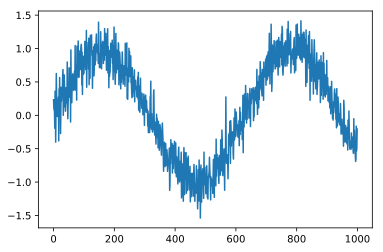

In [2]:
plt.plot(time.asnumpy(), x.asnumpy());

### Generating the Regression Dataset

In [3]:
features = nd.zeros((T-embedding, embedding))
for i in range(embedding):
    features[:,i] = x[i:T-embedding+i]
labels = x[embedding:]

ntrain = 600
train_data = gluon.data.ArrayDataset(features[:ntrain,:], labels[:ntrain])
test_data  = gluon.data.ArrayDataset(features[ntrain:,:], labels[ntrain:])

def get_net():
    net = gluon.nn.Sequential()
    net.add(gluon.nn.Dense(10, activation='relu'))
    net.add(gluon.nn.Dense(10, activation='relu'))
    net.add(gluon.nn.Dense(1))
    net.initialize(init.Xavier())
    return net

loss = gluon.loss.L2Loss()

### Training

In [4]:
# simple optimizer using adam, random shuffle and minibatch size 16
def train_net(net, data, loss, epochs, learningrate):
    batch_size = 16
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learningrate})
    data_iter = gluon.data.DataLoader(data, batch_size, shuffle=True)
    for epoch in range(1, epochs + 1):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        l = loss(net(data[:][0]), nd.array(data[:][1]))
        print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))
    return net

In [5]:
net = get_net()
net = train_net(net, train_data, loss, 10, 0.01)

l = loss(net(test_data[:][0]), nd.array(test_data[:][1]))
print('test loss: %f' % l.mean().asnumpy())

epoch 1, loss: 0.036634
epoch 2, loss: 0.030942
epoch 3, loss: 0.028760
epoch 4, loss: 0.028204
epoch 5, loss: 0.027514
epoch 6, loss: 0.027594
epoch 7, loss: 0.028184
epoch 8, loss: 0.028527
epoch 9, loss: 0.029737
epoch 10, loss: 0.026995
test loss: 0.024697


### Results

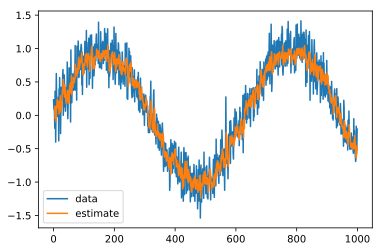

In [6]:
estimates = net(features)
plt.plot(time.asnumpy(), x.asnumpy(), label='data');
plt.plot(time[embedding:].asnumpy(), estimates.asnumpy(), label='estimate');
plt.legend();

## Predictions for more than 1 step

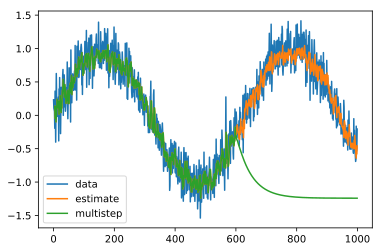

In [7]:
predictions = nd.zeros_like(estimates)
predictions[:(ntrain-embedding)] = estimates[:(ntrain-embedding)]
for i in range(ntrain-embedding, T-embedding):
    predictions[i] = net(predictions[(i-embedding):i].reshape(1,-1)).reshape(1)
    
plt.plot(time.asnumpy(), x.asnumpy(), label='data');
plt.plot(time[embedding:].asnumpy(), estimates.asnumpy(), label='estimate');
plt.plot(time[embedding:].asnumpy(), predictions.asnumpy(), label='multistep');
plt.legend();

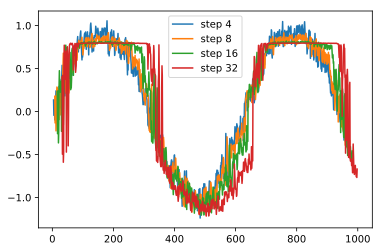

In [8]:
k = 33 # look up to k - embedding steps ahead
features = nd.zeros((T-k, k))
for i in range(embedding):
    features[:,i] = x[i:T-k+i]
for i in range(embedding, k):
    features[:,i] = net(features[:,(i-embedding):i]).reshape((-1))
for i in (4, 8, 16, 32):   
    plt.plot(time[i:T-k+i].asnumpy(), features[:,i].asnumpy(), label=('step ' + str(i)))
plt.legend();